In [1]:
# import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [9]:
# read the csv file
# set emotion as its index
face = pd.read_csv('/content/gdrive/My Drive/fer2013.csv')

In [10]:
face.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [11]:
face.shape

(35887, 3)

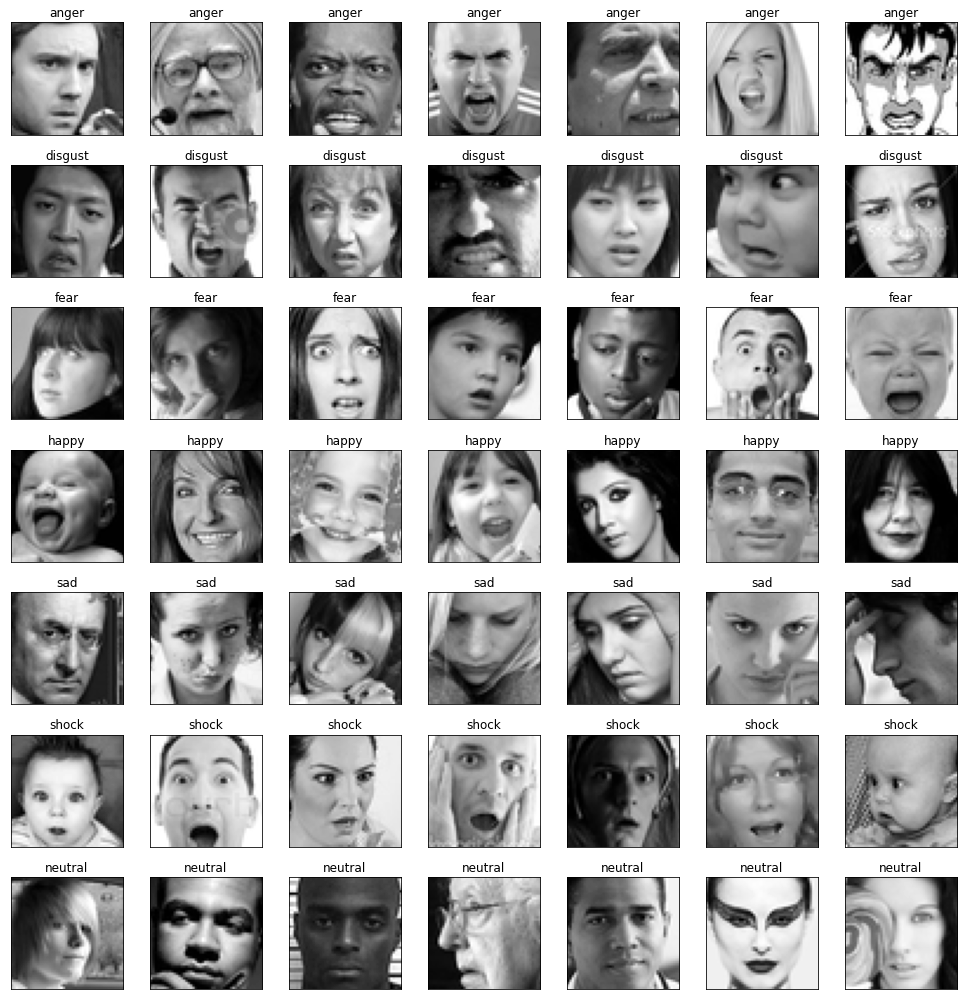

In [12]:
# look over the dataset and plot the image
fig = plt.figure(1, (14, 14))
emotion = ["anger", "disgust", "fear", "happy", "sad", "shock", "neutral"]

k = 0
for label in sorted(face['emotion'].unique()):
    for j in range(7):
        px = face[face.emotion == label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion[label])
        plt.tight_layout()

In [13]:
# count for every instances in the dataset
count = face['emotion'].value_counts().to_dict()
count

{0: 4953, 1: 547, 2: 5121, 3: 8989, 4: 6077, 5: 4002, 6: 6198}

In [14]:
keys = [key for key in count.keys()]
value = [value for value in count.values()]
print(keys)
print(value)

[3, 6, 4, 2, 0, 5, 1]
[8989, 6198, 6077, 5121, 4953, 4002, 547]


In [15]:
new_list = []
i = 0
for i in range(len(keys)):
  for label in emotion:
    if keys[i] == emotion.index(label):
      new_list.append(label)
new_list    

['happy', 'neutral', 'sad', 'fear', 'anger', 'shock', 'disgust']

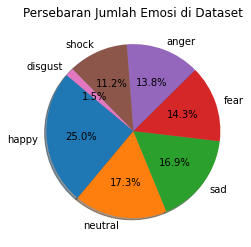

In [16]:
# plot into pie chart
plt.pie(value, labels=new_list, 
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title("Persebaran Jumlah Emosi di Dataset")
plt.show()

**Preprocessing Data**

In [17]:
# split data for traning and test
face.Usage.value_counts()

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64

In [18]:
training = face.loc[face["Usage"] == "Training"]
test = face.loc[face["Usage"] == "PublicTest"]

training.shape, test.shape

((28709, 3), (3589, 3))

In [114]:
# train data
train_img = training["pixels"].str.split(" ").tolist()
train_img = np.array(train_img).astype('float32')
train_img = train_img.reshape(train_img.shape[0], 48, 48, 1)

train_label = training["emotion"]
train_label = np_utils.to_categorical(train_label)

#test data
test_img = test["pixels"].str.split(" ").tolist()
test_img = np.array(test_img).astype('float32')
test_img = test_img.reshape(test_img.shape[0], 48, 48, 1)

test_label = test["emotion"]
test_label = np_utils.to_categorical(test_label)

In [48]:
train_img.shape, train_label.shape, test_img.shape, test_label.shape

((28709, 48, 48, 1), (28709, 7), (3589, 48, 48, 1), (3589, 7))

In [111]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

test_datagen = ImageDataGenerator(
    rescale=1./255)

In [112]:
train_datagen.fit(train_img)
test_datagen.fit(test_img)

In [113]:
train_generator = train_datagen.flow(
        train_img,
        train_label,
        batch_size=32)

test_generator = test_datagen.flow(
        test_img,
        test_label,
        batch_size=32)

**Build Model**

In [115]:
model = tf.keras.models.Sequential([
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (5,5), activation='relu', input_shape=(48, 48, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    # The fourth convolution
    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Dropout(0.2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [116]:
model.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_110 (Conv2D)          (None, 44, 44, 64)        1664      
_________________________________________________________________
max_pooling2d_74 (MaxPooling (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_111 (Conv2D)          (None, 20, 20, 64)        36928     
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 20, 20, 64)        36928     
_________________________________________________________________
max_pooling2d_75 (MaxPooling (None, 10, 10, 64)        0         
_________________________________________________________________
dropout_81 (Dropout)         (None, 10, 10, 64)        0         
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 8, 8, 128)       

In [117]:
model.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [36]:
my_callback = [ 
      tf.keras.callbacks.EarlyStopping(
          monitor='val_accuracy', 
          min_delta=0.5,
          patience=5,
          verbose=1,
      ),
      tf.keras.callbacks.ReduceLROnPlateau(
          monitor="val_loss", 
          factor=0.5, 
          patience=5,
          min_lr=1e-7,
          verbose=1,
      )
]

In [99]:
history = model.fit(train_img, train_label, batch_size=32, epochs=50, validation_data = (test_img,test_label), verbose = 1)

Epoch 1/50
898/898 [==============================] - 8s 8ms/step - loss: 1.8684 - accuracy: 0.2413 - val_loss: 1.7890 - val_accuracy: 0.2522
Epoch 2/50
898/898 [==============================] - 7s 8ms/step - loss: 1.8062 - accuracy: 0.2566 - val_loss: 1.8185 - val_accuracy: 0.2549
Epoch 3/50
898/898 [==============================] - 7s 8ms/step - loss: 1.8114 - accuracy: 0.2514 - val_loss: 1.8119 - val_accuracy: 0.2494
Epoch 4/50
898/898 [==============================] - 7s 8ms/step - loss: 1.8036 - accuracy: 0.2596 - val_loss: 1.7254 - val_accuracy: 0.3037
Epoch 5/50
898/898 [==============================] - 7s 8ms/step - loss: 1.7161 - accuracy: 0.3052 - val_loss: 1.5796 - val_accuracy: 0.3803
Epoch 6/50
898/898 [==============================] - 7s 8ms/step - loss: 1.5608 - accuracy: 0.3899 - val_loss: 1.4642 - val_accuracy: 0.4199
Epoch 7/50
898/898 [==============================] - 7s 8ms/step - loss: 1.4633 - accuracy: 0.4307 - val_loss: 1.4194 - val_accuracy: 0.4492
Epoch 

**Plotting Acc and Loss**

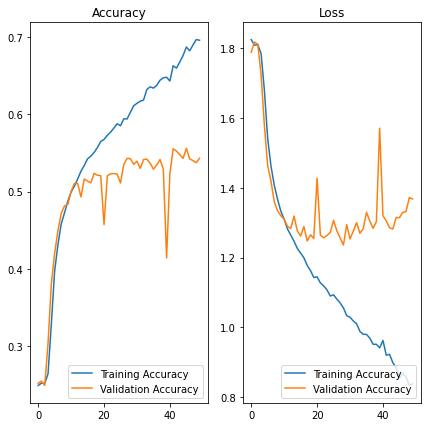

In [100]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(7,7))
plt.subplot(1,2,1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(epochs_range, loss, label='Training Accuracy')
plt.plot(epochs_range, val_loss, label='Validation Accuracy')
plt.title('Loss')
plt.legend(loc='lower right')
plt.show()

**Prediction**

In [110]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
from skimage import color
from skimage import io
from PIL import Image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, color_mode = "grayscale", target_size=(48, 48))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  classes = np.argmax(classes)
  label = ["anger", "disgust", "fear", "happy", "sad", "shock", "neutral"]
  
  print('\nPic name: {}'.format(fn))
  print('Prediction: {}'.format(label[classes]))

Saving 360_anger.jpg to 360_anger.jpg
Saving shock-face-asian-man-head-shot_39688-866.jpg to shock-face-asian-man-head-shot_39688-866 (9).jpg
Saving beautiful-asian-young-woman-sad-face-expression-emotion-despair-sadness-130837248.jpg to beautiful-asian-young-woman-sad-face-expression-emotion-despair-sadness-130837248 (10).jpg

Pic name: 360_anger.jpg
Prediction: fear

Pic name: shock-face-asian-man-head-shot_39688-866.jpg
Prediction: shock

Pic name: beautiful-asian-young-woman-sad-face-expression-emotion-despair-sadness-130837248.jpg
Prediction: sad
